**Name:** \_\_\_\_\_Huanchen Wang\_\_\_\_\_

**EID:** \_\_\_\_\_huancwang2\_\_\_\_\_

# CS5489 - Tutorial 8
## Face Detection with MLPs

In this tutorial you will train an MLP to detect whether there is a face in a small image patch.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
random.seed(100)
import skimage.io
import skimage.color
import skimage.transform
from scipy import ndimage

Next we will load keras and tensorflow.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import struct
K.set_image_data_format('channels_last')

In [3]:
import sys
print("Python:", sys.version, "Keras:", keras.__version__, "TF:", tf.__version__)

Python: 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)] Keras: 2.11.0 TF: 2.11.0


##  Loading Data and Pre-processing
Next we need to load the images.  Download `faces.zip`, and place it in the same directory as this ipynb file.  **Do not unzip it.** Then run the following cell to load the images.

In [4]:
imgdata = {'train':[], 'test':[]}
classes = {'train':[], 'test':[]}

# the dataset is too big, so subsample the training and test sets...
# reduce training set by a factor of 4
train_subsample = 1
train_counter = [0, 0]
# maximum number of samples in each class for test set
test_maxsample = 472
test_counter = [0, 0]

# load the zip file
filename = 'faces.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "faces/*/*/*.png"):
        
        # filename is : faces/train/face/fname.png
        (fdir1, fname)  = os.path.split(name)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (face, nonface)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        # class 1 = face; class 0 = non-face
        myclass = int(fclass == "face")  

        loadme = False
        if fset == 'train':
            if (train_counter[myclass] % train_subsample) == 0:
                loadme = True
            train_counter[myclass] += 1
        elif fset == 'test':
            if test_counter[myclass] < test_maxsample:
                loadme = True
            test_counter[myclass] += 1
            
        if (loadme):
            # open file in memory, and parse as an image
            myfile = zfile.open(name)
            #img = matplotlib.image.imread(myfile)
            img = skimage.io.imread(myfile, as_gray=True)
            myfile.close()
            
            # append data
            imgdata[fset].append(img)
            classes[fset].append(myclass)

        
zfile.close()
imgsize = img.shape

print(len(imgdata['train']))
print(len(imgdata['test']))
trainclass2start = sum(classes['train'])

6977
944


Next we will convert the list of images into a block (array) of images for easier processing.

In [5]:
# convert list to numpy array
trainY = asarray(classes['train'])
testY  = asarray(classes['test'])

# convert class labels to binary indicators
trainYb = keras.utils.to_categorical(trainY)
testYb  = keras.utils.to_categorical(testY)

# convert list of ndarray to ndarray
trainI = asarray(imgdata['train']).reshape((6977,19,19,1))
testI  = asarray(imgdata['test']).reshape((944,19,19,1))

# cleanup memory
del imgdata

# shuffle the data (since it is in order by class)
random.seed(123)
inds1 = random.permutation(len(trainI)).tolist()
inds2 = random.permutation(len(testI)).tolist()
trainYb = trainYb[inds1]
testYb  = testYb[inds2]
trainY = trainY[inds1]
testY  = testY[inds2]
trainI = trainI[inds1]
testI = testI[inds2]

print(trainI.shape)
print(testI.shape)

(6977, 19, 19, 1)
(944, 19, 19, 1)


Each image is a 19x19x1 array of pixel values.  The last dimension is the number of channels in the image - in this case the image is grayscale, so there is only 1 channel.  Run the below code to show an example:

(19, 19)


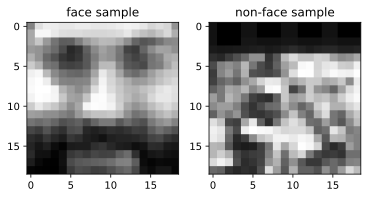

In [6]:
print(img.shape)
plt.subplot(1,2,1)
plt.imshow(squeeze(trainI[1]), cmap='gray', interpolation='nearest')
plt.title("face sample")
plt.subplot(1,2,2)
plt.imshow(squeeze(trainI[2]), cmap='gray', interpolation='nearest')
plt.title("non-face sample")
plt.show()

Run the below code to show more images!

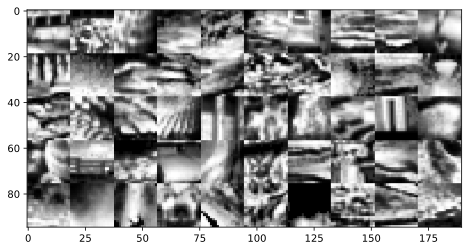

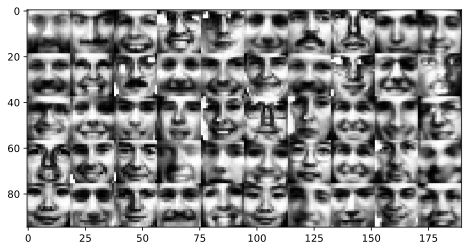

In [7]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(squeeze(X[i]))
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

# show images in a plot
def show_imgs(W_list, nc=10, highlight_green=None, highlight_red=None, titles=None):
    # nc is the number of columns
    nfilter = len(W_list)
    nr = (nfilter - 1) // nc + 1
    for i in range(nr):
        for j in range(nc):
            idx = i * nc + j
            if idx == nfilter:
                break
            plt.subplot(nr, nc, idx + 1)
            cur_W = W_list[idx]
            plt.imshow(cur_W,cmap='gray', interpolation='nearest')  
            if titles is not None:
                if isinstance(titles, str):
                    plt.title(titles.format(idx))
                else:
                    plt.title(titles[idx])
            
            if ((highlight_green is not None) and highlight_green[idx]) or \
               ((highlight_red is not None) and highlight_red[idx]): 
                ax = plt.gca()
                if highlight_green[idx]:
                    mycol = '#00FF00'
                else:
                    mycol = 'r'
                for S in ['bottom', 'top', 'right', 'left']:
                    ax.spines[S].set_color(mycol)
                    ax.spines[S].set_lw(2.0)
                ax.xaxis.set_ticks_position('none')               
                ax.yaxis.set_ticks_position('none')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                plt.gca().set_axis_off()

# show a few images
plt.figure(figsize=(9,4))
plt.imshow(image_montage(trainI[trainYb[:,0]==1][0:50]), cmap='gray', interpolation='nearest')
plt.show()

plt.figure(figsize=(9,4))
plt.imshow(image_montage(trainI[trainYb[:,1]==1][0:50]), cmap='gray', interpolation='nearest')
plt.show()

Next we will generate the training/validation set from the training data.

In [8]:
# generate fixed validation set of 10% of the training set
vtrainI, validI, vtrainYb, validYb = \
  model_selection.train_test_split(trainI, trainYb, 
  train_size=0.9, test_size=0.1, random_state=4488)

# make validation data
validsetI = (validI, validYb)

print(vtrainI.shape)
print(validI.shape)

(6279, 19, 19, 1)
(698, 19, 19, 1)


Here are some useful functions.

In [9]:
def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    
    if 'accuracy' in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history['accuracy'], 'b', label="training acc ({:.4f})".format(history.history['accuracy'][-1]))
        ax2.plot(history.history['val_accuracy'], 'b--', label="validation acc ({:.4f})".format(history.history['val_accuracy'][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')
        



Now let's try a simple logistic regression classifier, trained using Keras. Since the inputs are images, we will convert the input image into a vector using the "Flatten" layer first.

Epoch 9: early stopping
test accuracy: 0.6048728813559322


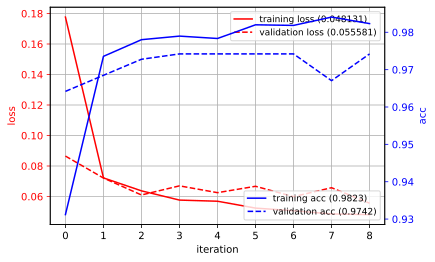

In [10]:
# initialize random seed
K.clear_session()
random.seed(4487); tf.random.set_seed(4487)

# build the network for logistic regression
nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # vectorize the input image
nn.add(Dense(units=2, activation='softmax'))  # classification layer (2 classes)

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_accuracy',      # use validation accuracy for stopping
               min_delta=0.0001, patience=5, 
               verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(learning_rate=0.05, momentum=0.9, nesterov=True), 
           metrics=['accuracy']  # also calculate accuracy during training
          )

history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validsetI,  # specify the validation set
                 verbose=False)

plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

## Detection using MLP

Train an MLP to classify an image patch as face or not face.  Use  `vtrainI` and `vtrainY` as the training set and `validsetI` as the validation set.  You can try different architectures, and adjust values of the learning rates, number of iterations, early stopping to get a good result.  Use a large batch size (e.g., 50) to speed up the training time.  Remember to add the `callbacks` so that you can monitor the training process.

In [11]:
### INSERT YOUR CODE HERE



Epoch 6: early stopping
learning rate:  0.5 test accuracy: 0.5
Epoch 18: early stopping
learning rate:  0.1 test accuracy: 0.6271186440677966
Epoch 19: early stopping
learning rate:  0.05 test accuracy: 0.6016949152542372
Epoch 17: early stopping
learning rate:  0.01 test accuracy: 0.6546610169491526


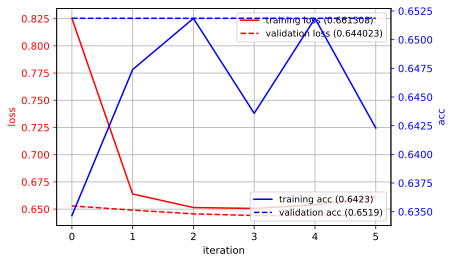

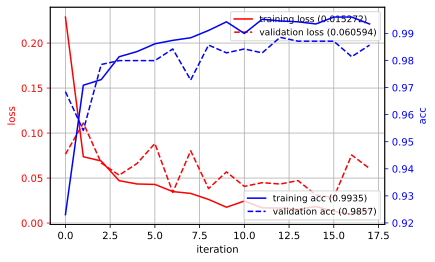

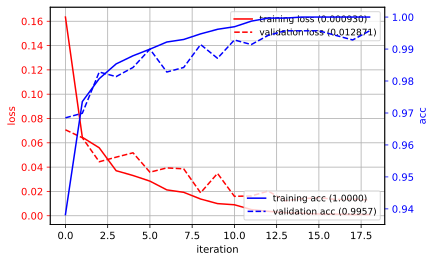

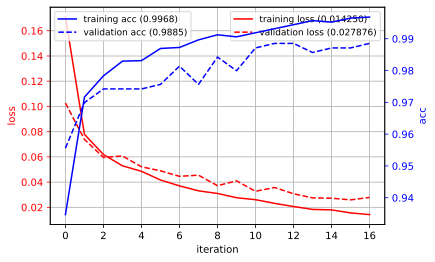

In [12]:
# First Architecture with only one hidden layer and using several learning rates

lr_list = [0.5, 0.1, 0.05, 0.01]
for i in range(len(lr_list)):
    K.clear_session()
    random.seed(4487); tf.random.set_seed(4487)

    nn = Sequential()
    nn.add(Flatten(input_shape=(19,19,1)))
    nn.add(Dense(units=100, activation='relu'))
    nn.add(Dense(units=2, activation='softmax'))

    earlystop = keras.callbacks.EarlyStopping(
                    monitor='val_accuracy',      # use validation accuracy for stopping
                    min_delta=0.0001, patience=5,
                    verbose=1, mode='auto')
    callbacks_list = [earlystop]

    nn.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.SGD(learning_rate=lr_list[i], momentum=0.9, nesterov=True),
                    metrics=['accuracy']  # also calculate accuracy during training
                    )

    history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50,
                        callbacks=callbacks_list,   
                        validation_data=validsetI,  # specify the validation set
                        verbose=False)

    plot_history(history)
    predY = argmax(nn.predict(testI, verbose=False), axis=-1)
    acc = metrics.accuracy_score(testY, predY)
    print('learning rate: ', lr_list[i], 'test accuracy:', acc)


Epoch 6: early stopping
test accuracy: 0.5
Epoch 17: early stopping
test accuracy: 0.676906779661017
Epoch 12: early stopping
test accuracy: 0.5805084745762712
Epoch 8: early stopping
test accuracy: 0.6896186440677966


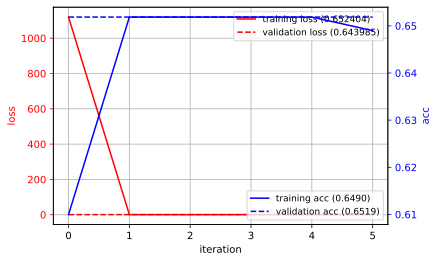

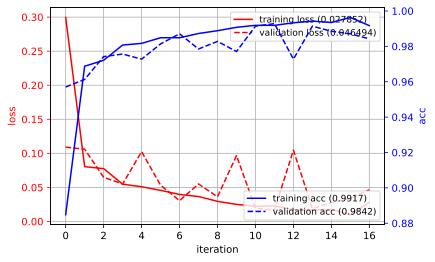

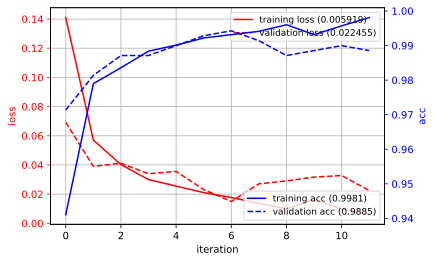

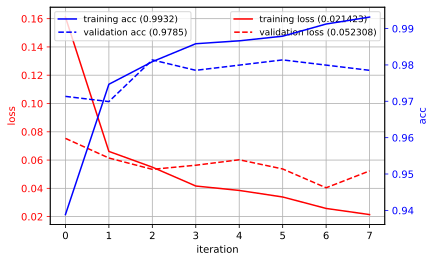

In [13]:
# Second Architecture with 2 hidden layers and using several learning rates

lr_list = [0.5, 0.1, 0.05, 0.01]

for i in range(len(lr_list)):
  K.clear_session()
  random.seed(4487); tf.random.set_seed(4487)

  nn = Sequential()
  nn.add(Flatten(input_shape=(19,19,1)))  
  nn.add(Dense(units=128, activation='relu'))
  nn.add(Dense(units=256, activation='relu'))
  nn.add(Dense(units=2, activation='softmax'))

  earlystop = keras.callbacks.EarlyStopping(
                  monitor='val_accuracy',
                  min_delta=0.0001, patience=5,
                  verbose=1, mode='auto')
  callbacks_list = [earlystop]

  nn.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.SGD(learning_rate=lr_list[i], momentum=0.9, nesterov=True),
                  metrics=['accuracy'])

  history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50,
                      callbacks=callbacks_list,
                      validation_data=validsetI,
                      verbose=False)

  plot_history(history)
  predY = argmax(nn.predict(testI, verbose=False), axis=-1)
  acc = metrics.accuracy_score(testY, predY)
  print("test accuracy:", acc)

_How does the MLP compare to the linear and non-linear classifiers that you tried in Tutorial 4?_
- **INSERT YOUR ANSWER HERE**

### Comparing to the Tutorial 4:
- In Tutorial 4, I trained:
  -  the AdaBoost, 
  -  XGBoost, 
  -  Random Forest, 
  -  poly kernel SVM, 
  -  and rbf kernel SVM. 
  
  The best model is the random forest classifier that achieves 0.681 accuracy for test set based on the original training dataset with cross validation.
- In this Tutorial, the MLP get the best performance when the learning rate is 0.01 with 2 Hidden Layers, the accuracy can reach to 0.689. It get a few improvement from the Tutorial 4's best classifier Random Forest.
- In conclusion, MLP performs better. It has higher accuracy, faster training speed. But, it get much more performance on the training and validation set. It seems more likely be overfitting.

## Data Augmentation

The reason why we are not getting good accuracy with MLP is because there is not a lot of data, only ~7000 training images, compared to the number of parameters in the MLP.

Augmenting the training data with permutations  (e.g., scaling, rotating, skewing, flipping) is a good way to create more "data" for training the network.
This can prevent the MLP from overfitting, and improve its generalization.  We will use the built-in `ImageDataGenerator` to apply geometric transformations.

We can also add per-pixel noise or transformations. We define a few functions for adding per-pixel noise.  The following functions will add Gaussian pixel noise, add corruption noise (setting some input pixels to 0), scale and shift pixel values (changing contrast and brightness).

In [10]:
def add_gauss_noise(X, sigma2=0.05):
    # add Gaussian noise with zero mean, and variance sigma2
    return X + random.normal(0, sigma2, X.shape)

def add_corrupt_noise(X, p=0.1):
    # apply pixel corruption (zero out value) with probability p
    return X * random.binomial(1, 1-p, X.shape)

def add_scale_shift(X, sigma2=0.1, alpha2=0.2):
    # randomly scale and shift the pixel values (same for each image)
    # Xnew = a X + b
    # a is sampled from a Gaussian with mean 1, and variance sigma2
    # b is sampled from a Gaussian with mean 0, and variance alpha2
    if X.ndim == 3:
        dshape = (X.shape[0],1,1)
    elif X.ndim == 4:
        dshape = (X.shape[0],1,1,1)
    else:
        dshape = (1,)
    a = random.normal(1,sigma2, dshape)
    b = random.normal(0,alpha2, dshape)
    return minimum(maximum( a*X + b, 0.0), 1.0)

Next, we define a function for adding per-pixel noise (in this case just Gaussian noise). The noise is included using the `preprocessing_function` input of the `ImageDataGenerator`.

In [11]:
# build the noise function
def addNoise(X):
    return add_gauss_noise(X, 0.04)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

Next we can show some examples of augmented images. Run the code below to see different random augmentations.

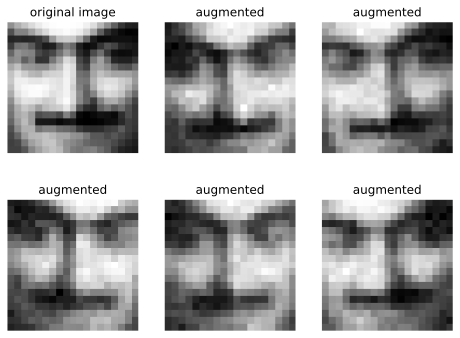

In [12]:
img = trainI[4]
imgs = [img[:,:,0]]

cnt = 0
for augimg, augy in datagen.flow(img.reshape(1,19,19,1), [1], batch_size=1):
    imgs.append(augimg[0,:,:,0])
    cnt += 1
    if cnt > 4:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break

titles = ['original image', 'augmented', 'augmented', 'augmented', 'augmented', 'augmented']
plt.figure(figsize=(8,6))
show_imgs(imgs, nc=3, titles=titles)

The augmented images look similar to the original image, but contain small differences that the network can use to learn more about the class.

Now let's try training logistic regression with data augmentation. Instead sending the X,Y data to `fit`, we now  send it through the ImageDataGenerator first.  We disable early stopping so that the network sees more noisy data.

In [13]:
# initialize random seed
K.clear_session()
random.seed(4487); tf.random.set_seed(4487)

# build the network for logistic regression
nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # vectorize the input image
nn.add(Dense(units=2, activation='softmax'))  # classification layer (2 classes)

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_accuracy',             # use validation accuracy for stopping
               min_delta=0.0001, patience=5, 
               verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(learning_rate=0.05, momentum=0.9, nesterov=True), 
           metrics=['accuracy']  # also calculate accuracy during training
          )

# fit with data generator
history = nn.fit(
            datagen.flow(vtrainI, vtrainYb, batch_size=100),  # data from generator
            steps_per_epoch=len(vtrainI)/100,    # should be number of batches per epoch
            epochs=50,
            callbacks=callbacks_list, 
            validation_data=validsetI, verbose=True)


Epoch 1/50
62/62 [==============================] - 2s 24ms/step - loss: 0.2789 - accuracy: 0.8864 - val_loss: 0.1295 - val_accuracy: 0.9456
Epoch 2/50
62/62 [==============================] - 1s 18ms/step - loss: 0.1779 - accuracy: 0.9271 - val_loss: 0.1108 - val_accuracy: 0.9556
Epoch 3/50
62/62 [==============================] - 1s 17ms/step - loss: 0.1690 - accuracy: 0.9334 - val_loss: 0.1169 - val_accuracy: 0.9513
Epoch 4/50
62/62 [==============================] - 1s 18ms/step - loss: 0.1572 - accuracy: 0.9382 - val_loss: 0.1310 - val_accuracy: 0.9427
Epoch 5/50
62/62 [==============================] - 1s 19ms/step - loss: 0.1593 - accuracy: 0.9357 - val_loss: 0.1095 - val_accuracy: 0.9542
Epoch 6/50
62/62 [==============================] - 1s 18ms/step - loss: 0.1573 - accuracy: 0.9365 - val_loss: 0.1104 - val_accuracy: 0.9585
Epoch 7/50
62/62 [==============================] - 1s 18ms/step - loss: 0.1545 - accuracy: 0.9382 - val_loss: 0.0974 - val_accuracy: 0.9613
Epoch 8/50
62

test accuracy: 0.663135593220339


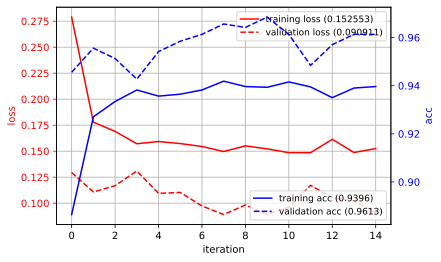

In [14]:
plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

Using data augmentation, the test accuracy improves from 0.66 to 0.69!

Now train your best MLP from the previous section using data augmentation. 
Try different per-pixel noise levels, and different options of the ImageDataGenerator (see [here](https://keras.io/preprocessing/image/)), 
and combinations of them.  Hopefully you should be able to improve the accuracy! 

In [19]:
### INSERT YOUR CODE HERE ###

In [15]:
def model_ac(dataAug):
    K.clear_session()
    random.seed(4487); tf.random.set_seed(4487)

    nn = Sequential()
    nn.add(Flatten(input_shape=(19,19,1)))
    nn.add(Dense(units=128, activation='relu'))
    nn.add(Dense(units=256, activation='relu'))
    nn.add(Dense(units=2, activation='softmax'))

    earlystop = keras.callbacks.EarlyStopping(
                    monitor='val_accuracy',
                    min_delta=0.0001, patience=5,
                    verbose=1, mode='auto')
    callbacks_list = [earlystop]

    nn.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.1, nesterov=True),
                    metrics=['accuracy'])

    history = nn.fit(
                dataAug.flow(vtrainI, vtrainYb, batch_size=100),
                steps_per_epoch=len(vtrainI)/100,
                epochs=50,
                callbacks=callbacks_list,
                validation_data=validsetI, verbose=False)

    return nn, history

Epoch 23: early stopping


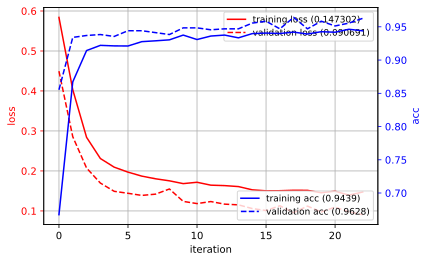

test accuracy: 0.7139830508474576


In [16]:
# Using the multiple layer perceptron model with data augmentation

model, history = model_ac(datagen)
plot_history(history)
plt.show()
predY = argmax(model.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

## Try different options of the ImageDataGenerator to find the best options


In [17]:
def select_opt(opt_name, dataaug):
    model, his = model_ac(dataaug)
    predY = argmax(model.predict(testI, verbose=False), axis=-1)
    acc = metrics.accuracy_score(testY, predY)
    print("test accuracy with {}={}: {}".format(opt_name,getattr(dataaug, opt_name),acc))
    return model, his

In [18]:
opt_dict = {'ratation_range': [10, 30, 40], 'width_shift_range': [0.05, 0.15, 0.2], 'height_shift_range': [0.05, 0.15, 0.2], 
            'shear_range': [0.05, 0.15, 0.2], 'zoom_range': [[1-0.01, 1+0.01], [1-0.1,1+0.1], [1-0.2,1+0.2]], 'horizontal_flip': [True, False]}

for k, v in opt_dict.items():
    for i in v:
        dataaug = ImageDataGenerator(
            rotation_range=0,         # image rotation
            width_shift_range=0,     # image shifting
            height_shift_range=0,    # image shifting
            shear_range=0,           # shear transformation
            zoom_range=0,            # zooming
            horizontal_flip=False,       # horizontal flipping
            data_format='channels_last')
        setattr(dataaug, k, i)
        model,his = select_opt(k, dataaug)


Epoch 12: early stopping
test accuracy with ratation_range=10: 0.6514830508474576
Epoch 26: early stopping
test accuracy with ratation_range=30: 0.6440677966101694
Epoch 39: early stopping
test accuracy with ratation_range=40: 0.6260593220338984
Epoch 17: early stopping
test accuracy with width_shift_range=0.05: 0.659957627118644
Epoch 26: early stopping
test accuracy with width_shift_range=0.15: 0.8167372881355932
Epoch 8: early stopping
test accuracy with width_shift_range=0.2: 0.7860169491525424
Epoch 20: early stopping
test accuracy with height_shift_range=0.05: 0.6927966101694916
Epoch 37: early stopping
test accuracy with height_shift_range=0.15: 0.7161016949152542
Epoch 36: early stopping
test accuracy with height_shift_range=0.2: 0.6705508474576272
Epoch 13: early stopping
test accuracy with shear_range=0.05: 0.6811440677966102
Epoch 23: early stopping
test accuracy with shear_range=0.15: 0.6514830508474576
Epoch 41: early stopping
test accuracy with shear_range=0.2: 0.62711864

### According to the result, set the best options for the ImageDataGenerator:
- rotation_range=10
- width_shift_range=0.15
- height_shift_range=0.15
- shear_range=0.05
- zoom_range=0.2
- horizontal_flip=True

## Try different noise function with different options

In [19]:
def diff_DA(func_name, para_list):
    if func_name == 'add_gauss_noise':
        def addNoise(X):
            return add_gauss_noise(X, para_list[0])
    elif func_name == 'add_corrupt_noise':
        def addNoise(X):
            return add_corrupt_noise(X, para_list[0])
    elif func_name == 'add_scale_shift':
        def addNoise(X):
            return add_scale_shift(X, para_list[0], para_list[1])
    else:
        print('Wrong function name!')

    datagen_w_noise = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.05,
        zoom_range=0.2,
        horizontal_flip=True,
        preprocessing_function=addNoise,
        data_format='channels_last')

    model, his = model_ac(datagen_w_noise)

    plot_history(his)
    plt.show()
    predY = argmax(model.predict(testI, verbose=False), axis=-1)
    acc = metrics.accuracy_score(testY, predY)
    print("test accuracy:", acc)
    return model, his
    

### Using add_gauss_noise with sigma=0.02


Epoch 10: early stopping


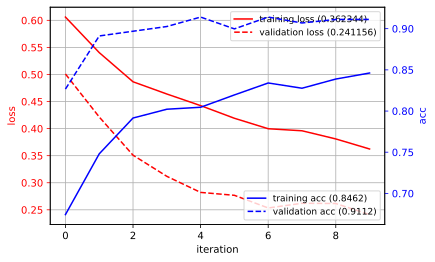

test accuracy: 0.836864406779661


In [43]:
model, history = diff_DA('add_gauss_noise', [0.02])

### Using add_gauss_noise with sigma=0.06

Epoch 13: early stopping


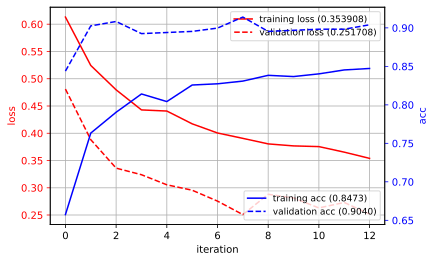

test accuracy: 0.8241525423728814


In [21]:
model, history = diff_DA('add_gauss_noise', [0.06])

### Using add_gauss_noise with sigma=0.1

Epoch 19: early stopping


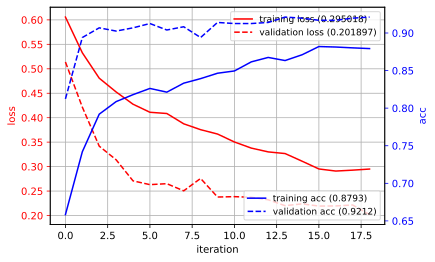

test accuracy: 0.8485169491525424


In [34]:
model, history = diff_DA('add_gauss_noise', [0.1])

### Using add_corrupt_noise with p=0.05

Epoch 7: early stopping


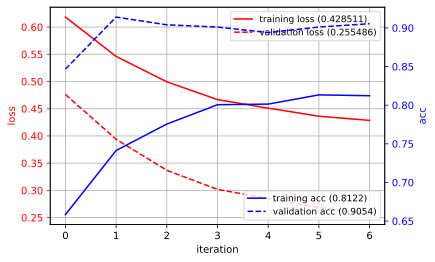

test accuracy: 0.8220338983050848


In [37]:
model, history = diff_DA('add_corrupt_noise', [0.05])

### Using add_corrupt_noise with p=0.5

Epoch 10: early stopping


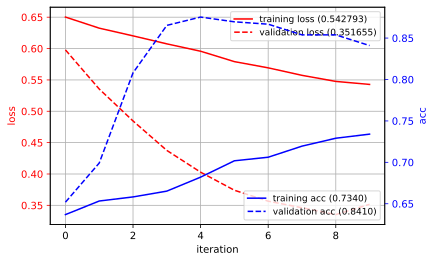

test accuracy: 0.7955508474576272


In [24]:
model , history = diff_DA('add_corrupt_noise', [0.5])

### Using add_corrupt_noise with p=0.8

Epoch 6: early stopping


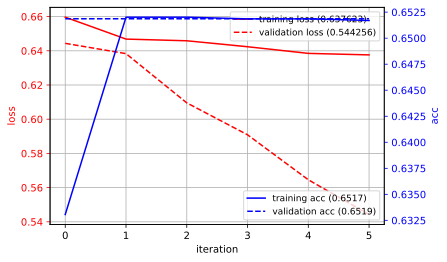

test accuracy: 0.5


In [25]:
model, history = diff_DA('add_corrupt_noise', [0.8])

### Using add_scale_shift with scale=0.1, shift=0.1

Epoch 9: early stopping


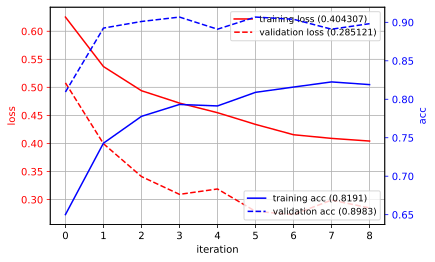

test accuracy: 0.8072033898305084


In [40]:
model, history = diff_DA('add_scale_shift', [0.1, 0.1])

### Using add_scale_shift with scale=0.5, shift=0.5

Epoch 11: early stopping


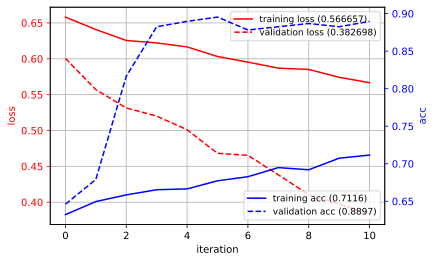

test accuracy: 0.8114406779661016


In [27]:
model, history = diff_DA('add_scale_shift', [0.5, 0.5])

### Using add_scale_shift with scale=0.8, shift=0.2

Epoch 13: early stopping


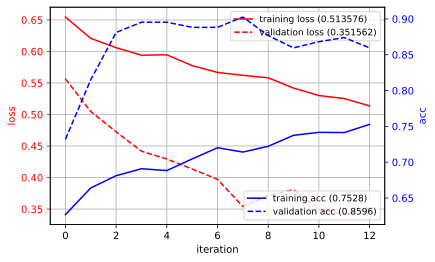

test accuracy: 0.8103813559322034


In [28]:
model, history = diff_DA('add_scale_shift', [0.8, 0.2])

_Which type of augmentation improves the accuracy the most?  Why?  How does NN with data augmentation compare with your work in Tutorial 4?_ 
- **INSERT YOUR ANSWER HERE**

### According to the results:
+ The the data augmentation with add **guassian noise** can get higher improvement level. 
  
  I try the 3 group parameters including: 0.01, 0.02, 0.1. The best one is **$\sigma=0.1$**. It can get the best accuracy **0.8485** on test dataset, which is also the highest accuracy in this tutorial.
+ Since the data augmentation can generate more data for training, which can increase the diversity of the data distribution. 
  
  Based on the result, I think the gaussian noise can make each image more different from each other than the other noise function. Besides, since the guassian with $\sigma=0.1$ can get better performance, I think the adding some guassian denstiry on some pixels has more influence to make the image more diversity in the add_guassain_noise noise function.
  
  Thus, the MLP can learn more from the data and get better performance and improve the model's robustness in test.
+ In Tutorial 4, I extracted features from the image using a set of filters.
  
  The filters are a sets of black and white boxes that respond to similar structures in the image.  After applying the filters to the image, the filter response map is aggregated over a 4x4 window.  Hence each filter produces a 5x5 feature response.  Since there are 4 filters, then the feature vector is 100 dimensions.

  After using the feature extraction, I got the best accuracy on test dataset is 0.82 using the random forest classifier.

  In this Tutorial, the data augmentation seems to increase the sample and the diversity of the data. But the feature extraction can extract the features from the image and make the data more meaningful. 

  Both of them can improve the performance of the model. But comparing to the results in my own code, their improvement level is similar.

# Test image
Now lets try your face detector on a real image.  Download the "nasa-small.png" image and put it in the same directory as your ipynb file.  The below code will load the image, crop out image patches and then extract features. (this may take a few minutes)

In [29]:
fname = "nasa-small.png"

(210, 480)


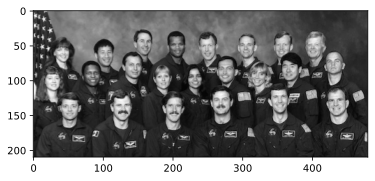

In [44]:
# load image
testimg = skimage.io.imread(fname, as_gray=True)
print(testimg.shape)
plt.imshow(testimg, cmap='gray')

In [45]:
# step size for the sliding window
step = 4

# extract window patches with step size of 4
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
psize = patches.shape
# collapse the first 2 dimensions
patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3], 1))
print(patches2.shape)

# histogram equalize patches (improves contrast)
#newI = empty(patches2.shape)
#for i in range(patches2.shape[0]):
#    newI[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:])
newI = patches2

(5568, 19, 19, 1)


Now predict using your classifier.  The extracted images are in `newI`.

In [46]:
### YOUR CODE HERE
prednewY = argmax(model.predict(newI, verbose=False), axis=-1)

Now we we will view the results on the image.  Use the below code. `prednewY` is the vector of predictions.

(-0.5, 479.5, 209.5, -0.5)

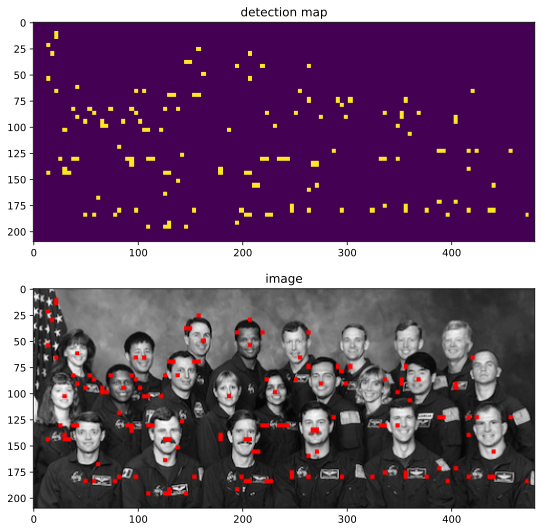

In [47]:
# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
# show detections with image
#detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))
nimgY2 = 1-imgY2
tmp = nimgY2*testimg
detimg = dstack((imgY2+tmp, tmp, tmp))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')

_How did your face detector do compared to the last version?_
- **INSERT YOUR ANSWER HERE**

### Comparing to the last version:
+ In the last version:
  + It pays more attention on the the field between nose and mouth to detect the face.
  
  + It gets a high FPR that detect many no-human facial pixel as the facial pixel.
  
  + Besids, in miss face-detecting, the classifier is more likely to detect the the pixels in medals and badges as the facial pixel.
+ In this version (Altough it get higher test accuracy):
  + It focus more face region to detect face, including the hear, nose, beard, neck and two sides of head.
  
  + However, it gets a much higher FPR that detect less no-human facial pixel as the facial pixel, especially do not detect the wall as the facial pixel.
  
  + Besides, it still classfiy some medals and badges as the facial pixel, but this situation is less than the last version.

You can try it on your own images.  The faces should all be around 19x19 pixels though.
We only used 1/8 of the training data. Try using more data to train it!

(270, 480)
(7308, 19, 19, 1)


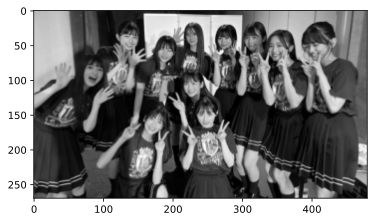

In [61]:
# predict my own image:
fname = "./5th.png"

# load image
testimg = skimage.io.imread(fname, as_gray=True)
print(testimg.shape)
plt.imshow(testimg, cmap='gray')

# step size for the sliding window
step = 4

# extract window patches with step size of 4
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
psize = patches.shape
# collapse the first 2 dimensions
patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3], 1))
print(patches2.shape)

# histogram equalize patches (improves contrast)
#newI = empty(patches2.shape)
#for i in range(patches2.shape[0]):
#    newI[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:])
newI_my = patches2


In [62]:
predY_my = argmax(model.predict(newI_my, verbose=False), axis=-1)

(-0.5, 479.5, 269.5, -0.5)

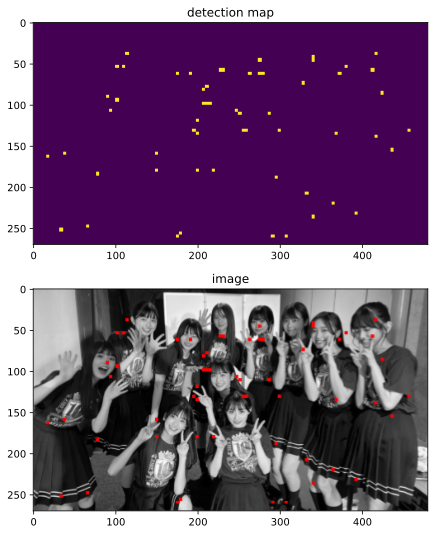

In [64]:
imgY_my = predY_my.reshape(psize[0], psize[1])

imgY2_my = ndimage.interpolation.zoom(imgY_my, step, output=None, order=0)
imgY2_my = vstack((zeros((9, imgY2_my.shape[1])), imgY2_my))
imgY2_my = hstack((zeros((imgY2_my.shape[0],9)), imgY2_my))
if (imgY2_my.shape[0] != testimg.shape[0]):
    imgY2_my = vstack((imgY2_my, zeros((testimg.shape[0]-imgY2_my.shape[0], imgY2_my.shape[1]))))
if (imgY2_my.shape[1] != testimg.shape[1]):
    imgY2_my = hstack((imgY2_my, zeros((imgY2_my.shape[0],testimg.shape[1]-imgY2_my.shape[1]))))

nimgY2_my = 1-imgY2_my
tmp = nimgY2_my*testimg
detimg_my = dstack((imgY2_my+tmp, tmp, tmp))

plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2_my, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg_my)
plt.title('image')
plt.axis('image')

